# **Landslide Detection over Time**

**Model: Multi-scale Attention U-Net**

**Code Author: Kushanav Bhuyan**



## Libraries

In [1]:
# Import the required Libraries

%load_ext autotime
print("Importing packages.......")

import os
import numpy as np
from osgeo import gdal
import tensorflow.keras
import tensorflow as tf

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config

%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from sklearn.model_selection import train_test_split
import pandas as pd

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras import backend as keras
from tensorflow.python.keras import backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.layers import LeakyReLU

import pickle
import matplotlib.pyplot as plt 
import sys

# print("Installing packages.......")

# !pip install keras-tqdm
# from keras_tqdm import TQDMCallback, TQDMNotebookCallback

# !pip install ipython-autotime
# %load_ext autotime
import imgaug.augmenters as iaa

print("Importing helper functions !!")

from utils import *
from losses import *
from attention_Unets import *

print("Libraries imported....")
print("Helpers imported....")

Importing packages.......
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


2022-04-07 11:01:07.852362: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Importing helper functions !!
Libraries imported....
Helpers imported....
time: 6.47 s (started: 2022-04-07 11:01:02 +02:00)


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Loading the data

### Define file directories

In [2]:
# Set file directory of the location where the data is stored
Data_folder= "path_to_data"

time: 414 µs (started: 2022-04-07 11:01:09 +02:00)


### Prepare required dataset
Make a list of the satellite images

In [3]:
def readdata(directory, folder_name):
      
    data_path = os.path.join(directory, folder_name)
    data_list = {}

    for f in sorted(os.listdir(data_path)):
        fdir = os.path.join(data_path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-45:-4] # Number of characters of the image file. Example, "Image_1.tif" = 11 characters
            image_data=gdal.Open(fdir)
            bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
            data_list[imgtype] = np.stack(bands, axis=2) 

    return data_list

time: 58.9 ms (started: 2022-04-07 11:01:09 +02:00)


In [4]:
image_list = readdata(directory=Data_folder, folder_name="Satellite images")
label_list = readdata(directory=Data_folder, folder_name="Label images")

time: 17.3 s (started: 2022-04-07 11:01:09 +02:00)


In [5]:
#Check If Everything Works (CIEW)
print("Number of satellite images: " + str(len(image_list)))
print("Shape of the image: "+ str(image_list["L1_train_2017"].shape))

print("Number of label images: " + str(len(label_list)))
print("Shape of the image: "+ str(label_list["L1_train_2017"].shape))

Number of satellite images: 17
Shape of the image: (2190, 2486, 5)
Number of label images: 19
Shape of the image: (2190, 2486, 1)
time: 772 µs (started: 2022-04-07 11:01:26 +02:00)


In [ ]:
# Print all the stacks that are collected
print("The collection of images available in the list are:")
print("-"*30)
print(*image_list, sep='\n')

### Visualise the images

In [7]:
# Visualise both satellite and label images together
# IMPORTANT NOTE: Use an 8-bit unsigned integer label image otherwise any other data type won't be visualised. 

sample_image="L3_train_2018"
sample_label="L3_train_2018"

def visualise_data(data,data2):
    f, axarr = plt.subplots(1,2)   
    data = data.astype(float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data[:,:,3])
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0].astype("uint8"))
    a.set_title("Labelled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["Background", "Landslide footprints"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# visualise_data(image_list[sample_image],label_list[sample_label])

time: 31.1 ms (started: 2022-04-07 11:01:26 +02:00)


## Design patches, encode into categorical data, remove zero patches, and data augmentations


### Generate Patches and encode

In [8]:
def gridwise_sample(imgarray, patchsize):

    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

time: 33.7 ms (started: 2022-04-07 11:01:26 +02:00)


In [9]:
# FOR GENERATING TRAINING SITES

PATCHSIZE = 128 # 224
NBANDS = image_list["L1_train_2017"].shape[-1]

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)

# Sample each training tile systematically in a gridwise manner
train_areas = ["add images here"]

for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

print(np.unique(Ytrain))
# Encode all landslide and background labels into their respective classes "0" and "1" (Categorical)
Ytrain[Ytrain==0] = 0
# Ytrain[Ytrain==-1] = 0
Ytrain[Ytrain==255] = 1
print(np.unique(Ytrain))

print("There are %i number of training patches" % (Xtrain.shape[0]))

[  0. 255.]
[0. 1.]
There are 2880 number of training patches
time: 20.7 s (started: 2022-04-07 11:01:26 +02:00)


In [10]:
#CIEW for training patches
bd_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
bg_px=len(Ytrain[Ytrain==0])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))

print("Pixel percentage of landslides = " + str(bd_px* 100)+ " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

Pixel percentage of landslides = 8.721563551161024 %
Pixel percentage of background = 91.27843644883897 %
time: 561 ms (started: 2022-04-07 11:01:47 +02:00)


In [11]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain, test_size=0.33, random_state=42)

time: 441 ms (started: 2022-04-07 11:01:47 +02:00)


In [12]:
# # FOR GENERATING TEST SITES

# Xtest = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
# Ytest = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)

# # Sample each testing tile systematically in a gridwise manner

# test_areas = ["image_2019_T14"]
# for area in test_areas:
#     X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
#     Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
#     Xtest = np.concatenate((Xtest, X_toadd), axis=0)
#     Ytest = np.concatenate((Ytest, Y_toadd), axis=0)

# print(np.unique(Ytest))
# # encode all landslide and background classes as one class (Categorical)
# Ytest[Ytest==0] = 0
# Ytest[Ytest==65535] = 0
# Ytest[Ytest!=0] = 1
# print(np.unique(Ytest))

# print("There are %i number of testing patches" % (Xtest.shape[0]))

time: 609 µs (started: 2022-04-07 11:01:48 +02:00)


In [13]:
#CIEW for test patches
bd_px=len(Ytest[Ytest==1])/(len(Ytest[Ytest==1])+len(Ytest[Ytest==0]))
bg_px=len(Ytest[Ytest==0])/(len(Ytest[Ytest==1])+len(Ytest[Ytest==0]))

print("Pixel percentage of landslides = " + str(bd_px* 100) + " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

Pixel percentage of landslides = 8.21032599319795 %
Pixel percentage of background = 91.78967400680204 %
time: 216 ms (started: 2022-04-07 11:01:48 +02:00)


### Remove Zero Patches

In [14]:
def remove_zeros(images_array,masks_array):
    
    all_zeros = []
    for i in range(masks_array.shape[0]):
        if masks_array[i].max() == 0:
            all_zeros.append(i)
    print("There are: {} arrays with just 0 values, and {} arrays with non zero values ".format(len(all_zeros), (
                images_array.shape[0] - len(all_zeros))))
    images = []
    masks = []
    for i in range(images_array.shape[0]):
        if i not in all_zeros:
            images.append(images_array[i])
            masks.append(masks_array[i])

    # Convert to array
    images = np.array(images, dtype="float64")
    masks = np.array(masks, dtype="float32")
    print("Image shape: {}, Mask shape: {}".format(images.shape, masks.shape))
    return images, masks

time: 926 µs (started: 2022-04-07 11:01:48 +02:00)


In [15]:
X_train, Y_train = remove_zeros(Xtrain, Ytrain)

print("----"*15)

X_test, Y_test = remove_zeros(Xtest, Ytest)

print("----"*15)

print("There are %i number of training patches" % (X_train.shape[0]))
print("There are %i number of testing patches" % (X_test.shape[0]))

There are: 757 arrays with just 0 values, and 1172 arrays with non zero values 
Image shape: (1172, 128, 128, 5), Mask shape: (1172, 128, 128, 1)
------------------------------------------------------------
There are: 382 arrays with just 0 values, and 569 arrays with non zero values 
Image shape: (569, 128, 128, 5), Mask shape: (569, 128, 128, 1)
------------------------------------------------------------
There are 1172 number of training patches
There are 569 number of testing patches
time: 560 ms (started: 2022-04-07 11:01:48 +02:00)


In [16]:
#CIEW for training patches
bd_px=len(Y_train[Y_train==1])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))
bg_px=len(Y_train[Y_train==0])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))

print("Pixel percentage of landslides = " + str(bd_px* 100)+ " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

Pixel percentage of landslides = 14.769695399157424 %
Pixel percentage of background = 85.23030460084257 %
time: 225 ms (started: 2022-04-07 11:01:49 +02:00)


In [17]:
#CIEW for testing patches
bd_px=len(Y_test[Y_test==1])/(len(Y_test[Y_test==1])+len(Y_test[Y_test==0]))
bg_px=len(Y_test[Y_test==0])/(len(Y_test[Y_test==1])+len(Y_test[Y_test==0]))

print("Pixel percentage of landslides = " + str(bd_px* 100)+ " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

Pixel percentage of landslides = 13.722355043112918 %
Pixel percentage of background = 86.27764495688707 %
time: 75.3 ms (started: 2022-04-07 11:01:49 +02:00)


### Data augmentations

In [18]:
print(f'Shape of the image collection before augmentation: {X_train.shape}')
print(f'Shape of the label collection before augmentation: {Y_train.shape}')

# Geometric
seq = iaa.Sequential([
    iaa.Fliplr(1)
])
seq1 = iaa.Sequential([
    iaa.Flipud(1)
])

seq2 = iaa.Sequential([
    iaa.ShearX((-20, 20))
])

seq3 = iaa.Sequential([
    iaa.ShearY((-20, 20))
])

seq4 = iaa.Sequential([
    iaa.Rotate((-45, 45))
])

# Horizontal Flip
X_aug, Y_aug = seq(images=X_train, heatmaps=Y_train)
# Vertical Flip
X_aug1, Y_aug1 = seq1(images=X_train, heatmaps=Y_train)
# Shear X
X_aug2, Y_aug2 = seq2(images=X_train, heatmaps=Y_train)
# Shear Y
X_aug3, Y_aug3 = seq3(images=X_train, heatmaps=Y_train)
# Rotate +-45
X_aug4, Y_aug4 = seq4(images=X_train, heatmaps=Y_train)

# X_train = np.concatenate((X_train, X_aug1, X_aug2, X_aug3,  X_aug4), axis=0)
# Y_train = np.concatenate((Y_train, Y_aug1, Y_aug2, Y_aug3,  Y_aug4), axis=0)

# Radiometric
seq5 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.0, 3.0))
])

seq6 = iaa.Sequential([
    iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
])

# seq7 = iaa.Sequential([
#     iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))
# ])

# Blur
X_aug5, Y_aug5 = seq5(images=X_train, heatmaps=Y_train)
# Sharp
X_aug6, Y_aug6 = seq6(images=X_train, heatmaps=Y_train)
# # Noise
# X_aug7, Y_aug7 = seq7(images=X_train.astype(np.uint8), heatmaps=Y_train)

X_train = np.concatenate((X_train, X_aug1, X_aug2, X_aug3,  X_aug4, X_aug5 ,X_aug6), axis=0)
Y_train = np.concatenate((Y_train, Y_aug1, Y_aug2, Y_aug3,  Y_aug4, Y_aug5 ,Y_aug6), axis=0)

print("--"*20)
print(f'Shape of the image collection after augmentation: {X_train.shape}')
print(f'Shape of the label collection after augmentation: {Y_train.shape}')

Shape of the image collection before augmentation: (1172, 128, 128, 5)
Shape of the label collection before augmentation: (1172, 128, 128, 1)
----------------------------------------
Shape of the image collection after augmentation: (8204, 128, 128, 5)
Shape of the label collection after augmentation: (8204, 128, 128, 1)
time: 18.6 s (started: 2022-04-07 11:01:49 +02:00)


In [19]:
print("There are %i number of training patches" % (X_train.shape[0]))

#CIEW for training patches
bd_px=len(Y_train[Y_train==1])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))
bg_px=len(Y_train[Y_train==0])/(len(Y_train[Y_train==1])+len(Y_train[Y_train==0]))

print("----"*15)

print("Pixel percentage of landslides = " + str(bd_px* 100)+ " %") 
print("Pixel percentage of background = " + str(bg_px* 100)+ " %")

There are 8204 number of training patches
------------------------------------------------------------
Pixel percentage of landslides = 13.729523265246193 %
Pixel percentage of background = 86.27047673475381 %
time: 1.86 s (started: 2022-04-07 11:02:08 +02:00)


In [20]:
# # Save train and test as NP arrays 

# np.save("Arrays/X_train_2.npy", X_train)
# np.save("Arrays/Y_train_2.npy", Y_train)
# np.save("Arrays/X_test_2.npy", X_test)
# np.save("Arrays/Y_test_2.npy", Y_test)

time: 341 µs (started: 2022-04-07 11:02:09 +02:00)


In [21]:
# # LOAD ARRAYS IF YOU ARE USING NP ARRAYS

# train_x = np.load("Arrays/X_train.npy")
# test_x = np.load("Arrays/X_test.npy")
# train_y = np.load("Arrays/Y_train.npy")
# test_y = np.load("Arrays/Y_test.npy")

# train_x_2 = np.load("Arrays/X_train_2.npy")
# test_x_2 = np.load("Arrays/X_test_2.npy")
# train_y_2 = np.load("Arrays/Y_train_2.npy")
# test_y_2 = np.load("Arrays/Y_test_2.npy")

time: 81.2 ms (started: 2022-04-07 11:02:09 +02:00)


In [22]:
# print(train_x.shape)
# print(train_y.shape)

# print(train_x_2.shape)
# print(train_y_2.shape)

time: 27.4 ms (started: 2022-04-07 11:02:10 +02:00)


In [23]:
# # Concatenate the different arrays

# X_train = np.concatenate((train_x, train_x_2), axis=0)
# Y_train = np.concatenate((train_y, train_y_2), axis=0)
# X_test = np.concatenate((test_x, test_x_2), axis=0)
# Y_test = np.concatenate((test_y, test_y_2), axis=0)

# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

time: 40.4 ms (started: 2022-04-07 11:02:10 +02:00)


In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

time: 2.32 s (started: 2022-04-07 11:02:10 +02:00)


## Training the model 

In [25]:
# Number of epochs
NUMBER_EPOCHS = 100

# List of hyperparameters
PATCHSIZE=128
NBANDS=5

lr = [1e-4]
batch_size_list = [8]
filters = [32]

# Dictionary of results
results = {
           "filters": [],
           "learning_rate": [],
           "batch_size": [],
           "loss": [],
           "accuracy": [],
           "precision": [],
           "recall": [],
           "f1": []
           }

# Multi-scales for training and testing
gt1 = Y_train[:,::8,::8,:]
gt2 = Y_train[:,::4,::4,:]
gt3 = Y_train[:,::2,::2,:]
gt4 = Y_train
gt_train = [gt1,gt2,gt3,gt4]

gv1 = Y_val[:,::8,::8,:]
gv2 = Y_val[:,::4,::4,:]
gv3 = Y_val[:,::2,::2,:]
gv4 = Y_val
gv_val = [gv1,gv2,gv3,gv4]

gte1 = Y_test[:,::8,::8,:]
gte2 = Y_test[:,::4,::4,:]
gte3 = Y_test[:,::2,::2,:]
gte4 = Y_test
gt_test = [gte1,gte2,gte3,gte4]

# Choose pre-trained weights if necessary for transfer learning
pretrained_weights = "Checkpoints/try.hdf5"

for learning_rate in lr:

    for batch_size in batch_size_list:

        for no_filters in filters:

            # Define the model architecture
            def ms_attUNet(lr,filtersFirstLayer, pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS)):

                img_input = Input(shape=input_size, name='input_scale1')
                scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='input_scale2')(img_input)
                scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='input_scale3')(scale_img_2)
                scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='input_scale4')(scale_img_3)

                conv1 = UnetConv2D(img_input, filtersFirstLayer, is_batchnorm=True, name='conv1')
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

                input2 = Conv2D(filtersFirstLayer*2, (3, 3), padding='same', activation='relu', name='conv_scale2')(scale_img_2)
                input2 = concatenate([input2, pool1], axis=3)
                conv2 = UnetConv2D(input2, filtersFirstLayer*2, is_batchnorm=True, name='conv2')
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

                input3 = Conv2D(filtersFirstLayer*4, (3, 3), padding='same', activation='relu', name='conv_scale3')(scale_img_3)
                input3 = concatenate([input3, pool2], axis=3)
                conv3 = UnetConv2D(input3, filtersFirstLayer*4, is_batchnorm=True, name='conv3')
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

                input4 = Conv2D(filtersFirstLayer*8, (3, 3), padding='same', activation='relu', name='conv_scale4')(scale_img_4)
                input4 = concatenate([input4, pool3], axis=3)
                conv4 = UnetConv2D(input4, filtersFirstLayer*2, is_batchnorm=True, name='conv4')
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                center = UnetConv2D(pool4, filtersFirstLayer*16, is_batchnorm=True, name='center')

                g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
                attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, '_1')
                up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')

                g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
                attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, '_2')
                up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

                g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
                attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, '_3')
                up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

                up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')

                conv6 = UnetConv2D(up1, filtersFirstLayer*8, is_batchnorm=True, name='conv6')
                conv7 = UnetConv2D(up2, filtersFirstLayer*4, is_batchnorm=True, name='conv7')
                conv8 = UnetConv2D(up3, filtersFirstLayer*2, is_batchnorm=True, name='conv8')
                conv9 = UnetConv2D(up4, filtersFirstLayer, is_batchnorm=True, name='conv9')

                out6 = Conv2D(1, (1, 1), activation='sigmoid', name='pred1')(conv6)
                out7 = Conv2D(1, (1, 1), activation='sigmoid', name='pred2')(conv7)
                out8 = Conv2D(1, (1, 1), activation='sigmoid', name='pred3')(conv8)
                out9 = Conv2D(1, (1, 1), activation='sigmoid', name='final')(conv9)

                model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9])

                loss = {'pred1':focal_tversky,
                        'pred2':focal_tversky,
                        'pred3':focal_tversky,
                        'final':losses.tversky_loss}

                loss_weights = {'pred1':1,
                                'pred2':1,
                                'pred3':1,
                                'final':1}
                model.compile(optimizer=Adam(learning_rate=lr), loss=loss, loss_weights=loss_weights,
                              metrics=metrics)
                # model.summary()
                
                if(pretrained_weights):
                    model.load_weights(pretrained_weights)
                    
                return model
            
            # Load the model
            model = ms_attUNet(lr=learning_rate, filtersFirstLayer=no_filters,pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS))
    
            print("---------------------------------------------------------------------------------------------------------------------")

            print("Initialising in 3..........2..........1......................................")

            print(f'Training on {X_train.shape[0]} images with learning rate {learning_rate}, batch size {batch_size}, and number of filters {no_filters}')

            # Checkpoint for saving the weights 
            checkpoint_path = os.path.join('Checkpoints/','weights.{epoch:02d}-{val_final_loss:.2f}.hdf5')

            # Create a callback that saves the model's weights at every epoch
            callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                            save_weights_only=True, save_best_only=True, monitor="val_final_loss", mode = "min",
                                                            verbose=1)

            # Create a callback to reduce the learning rate using the ReduceLROnPlateau function
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_final_loss", factor=0.33, patience=15, mode="min")
            
            early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_final_loss', # what is the metric to measure
                              patience = 40, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the mod
            
            # Compile the checkpoints and other settings as a callback
            callback_list = [callback, reduce_lr, early_stop]

            history = model.fit(X_train, gt_train,
                        epochs=NUMBER_EPOCHS,
                        batch_size=batch_size,
                        # validation_split = 0.1,
                        validation_data=(X_val, gv_val),
                        callbacks=callback_list,
                        verbose=2) 

            ########      EVALUATION      ###########
            tf.keras.backend.clear_session()
            evaluate = model.evaluate(X_test, gt_test, verbose=2)

            ########      Saving results      ###########
            results["filters"].append(no_filters)
            results["learning_rate"].append(learning_rate)
            results["batch_size"].append(batch_size)
            results["loss"].append(evaluate[16])
            results["accuracy"].append(evaluate[17])
            results["precision"].append(evaluate[18])
            results["recall"].append(evaluate[19])
            results["f1"].append(evaluate[20])

            # Convert results to a pandas dataframe
            results_df = pd.DataFrame(results)

            # Export as a CSV
            save_path_results = f'Results in CSV'
            if not os.path.exists(save_path_results):
                os.makedirs(save_path_results)

            results_df.to_csv(f'{save_path_results}/learning_rate_{learning_rate}_batch_size_{batch_size}_filters_{no_filters}.csv', index=False)

            tf.compat.v1.reset_default_graph()

            print(f"The metrics for the test set with learning rate {learning_rate},  filters {no_filters}, and batch size {batch_size} is {evaluate}")
            print("__________________________________________________________________________________________________________________________________________________________________________")

---------------------------------------------------------------------------------------------------------------------
Initialising in 3..........2..........1......................................
Training on 5496 images with learning rate 0.0001, batch size 8, and number of filters 32
Epoch 1/100

Epoch 00001: val_final_loss improved from inf to 0.49796, saving model to Checkpoints/weights.01-0.50.hdf5
687/687 - 55s - loss: 2.2875 - pred1_loss: 0.5952 - pred2_loss: 0.5829 - pred3_loss: 0.5883 - final_loss: 0.5211 - pred1_accuracy: 0.6987 - pred1_precision_m: 0.2936 - pred1_recall_m: 0.7697 - pred1_f1_m: 0.4145 - pred2_accuracy: 0.7035 - pred2_precision_m: 0.3024 - pred2_recall_m: 0.7919 - pred2_f1_m: 0.4271 - pred3_accuracy: 0.7137 - pred3_precision_m: 0.3074 - pred3_recall_m: 0.7772 - pred3_f1_m: 0.4294 - final_accuracy: 0.6623 - final_precision_m: 0.2811 - final_recall_m: 0.8303 - final_f1_m: 0.4101 - val_loss: 2.2522 - val_pred1_loss: 0.5894 - val_pred2_loss: 0.5911 - val_pred3_loss

## Testing the model

### Evaluate the model

LOAD MODELS FROM SAVED WEIGHTS (FOR PARTICULAR EPOCH WITH BEST PERFORMANCE)

In [20]:
# To load model weights from older runs, if present.
# Please load previous metrics and functions and other required variables.
# Also, insert the argument values manually for the model.

# Define the model architecture
            def ms_attUNet(lr,filtersFirstLayer, pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS)):

                img_input = Input(shape=input_size, name='input_scale1')
                scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='input_scale2')(img_input)
                scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='input_scale3')(scale_img_2)
                scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='input_scale4')(scale_img_3)

                conv1 = UnetConv2D(img_input, filtersFirstLayer, is_batchnorm=True, name='conv1')
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

                input2 = Conv2D(filtersFirstLayer*2, (3, 3), padding='same', activation='relu', name='conv_scale2')(scale_img_2)
                input2 = concatenate([input2, pool1], axis=3)
                conv2 = UnetConv2D(input2, filtersFirstLayer*2, is_batchnorm=True, name='conv2')
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

                input3 = Conv2D(filtersFirstLayer*4, (3, 3), padding='same', activation='relu', name='conv_scale3')(scale_img_3)
                input3 = concatenate([input3, pool2], axis=3)
                conv3 = UnetConv2D(input3, filtersFirstLayer*4, is_batchnorm=True, name='conv3')
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

                input4 = Conv2D(filtersFirstLayer*8, (3, 3), padding='same', activation='relu', name='conv_scale4')(scale_img_4)
                input4 = concatenate([input4, pool3], axis=3)
                conv4 = UnetConv2D(input4, filtersFirstLayer*2, is_batchnorm=True, name='conv4')
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                center = UnetConv2D(pool4, filtersFirstLayer*16, is_batchnorm=True, name='center')

                g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
                attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, '_1')
                up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')

                g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
                attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, '_2')
                up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

                g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
                attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, '_3')
                up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

                up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')

                conv6 = UnetConv2D(up1, filtersFirstLayer*8, is_batchnorm=True, name='conv6')
                conv7 = UnetConv2D(up2, filtersFirstLayer*4, is_batchnorm=True, name='conv7')
                conv8 = UnetConv2D(up3, filtersFirstLayer*2, is_batchnorm=True, name='conv8')
                conv9 = UnetConv2D(up4, filtersFirstLayer, is_batchnorm=True, name='conv9')

                out6 = Conv2D(1, (1, 1), activation='sigmoid', name='pred1')(conv6)
                out7 = Conv2D(1, (1, 1), activation='sigmoid', name='pred2')(conv7)
                out8 = Conv2D(1, (1, 1), activation='sigmoid', name='pred3')(conv8)
                out9 = Conv2D(1, (1, 1), activation='sigmoid', name='final')(conv9)

                model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9])

                loss = {'pred1':focal_tversky,
                        'pred2':focal_tversky,
                        'pred3':focal_tversky,
                        'final':losses.tversky_loss}

                loss_weights = {'pred1':1,
                                'pred2':1,
                                'pred3':1,
                                'final':1}
                model.compile(optimizer=Adam(learning_rate=lr), loss=loss, loss_weights=loss_weights,
                              metrics=metrics)
                # model.summary()
                
                if(pretrained_weights):
                    model.load_weights(pretrained_weights)
                    
                return model

best_model = UNet(loss=tversky_loss, lr=1e-4, filters=32,pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS))
best_model.load_weights("Checkpoints/weights.97-0.28.hdf5")
results = best_model.evaluate(Xtest, gt_test, verbose=0)
print(f'The metric evaluations are {results}')

# RUN TO SAVE THE MODEL IF YOU HAVE NOT SET ANY CHECKPOINTS; OTHERWISE NO NEED TO RUN THIS CODE
# This saves the weight as the model (might not be the best; depends which one you choose)

# import imp, h5py
# imp.reload(h5py)
# model_fname = "Checkpoints/2018_new.hdf5".format(filters, batch_size_list, lr)
# best_model.save(model_fname)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

LOAD MODELS FROM CURRENT RUN (Last Model)

In [38]:
# To load model from current run
model.evaluate(Xtest, Ytest, verbose=2)

9/9 - 1s - loss: -1.7326e+00 - accuracy: 0.8880 - precision_m: 36.7652 - recall_m: 0.9646 - f1_m: 1.8735


[-1.7325900793075562,
 0.8880049586296082,
 36.765220642089844,
 0.9645809531211853,
 1.8735079765319824]

### Predict the model 

In [33]:
def visualize_prediction(data,mask,predict):
    f, axarr = plt.subplots(1,3)
    data = data[:, :, 3] 
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(mask.ravel())
    im = axarr[1].imshow(mask[:,:,0])
    a.set_title("Ground truth labeled image")
    colors = [im.cmap(im.norm(value)) for value in values]

    b=axarr[2]
    values = np.unique(predict.ravel())
    im = axarr[2].imshow(predict[:,:,0])
    b.set_title("Predicted image")
    colors = [im.cmap(im.norm(value)) for value in values]

    mask = ["Background", "Landslide footprints"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), mask)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

Precision:  tf.Tensor(0.0, shape=(), dtype=float32)
Recall:  tf.Tensor(0.0, shape=(), dtype=float32)
F1-score:  tf.Tensor(0.0, shape=(), dtype=float32)
Site number= 212


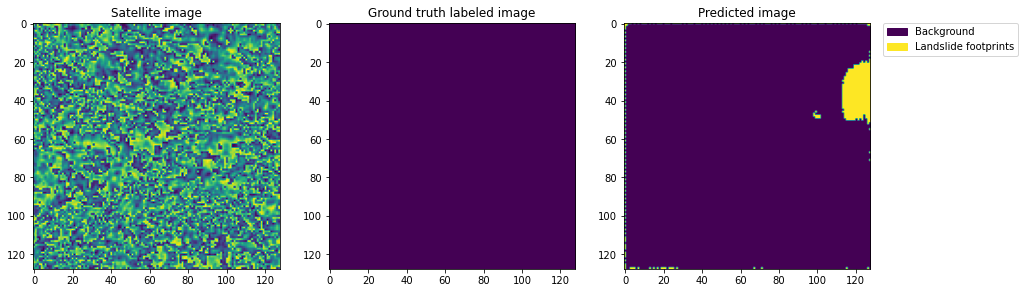

In [37]:
# Select the model and predict on the test image
prediction = model.predict(Xtest)

# Run this code if the predicted data needs to be in "int" type and if you need to do THRESHOLDING.
prediction[prediction>0.5]=1
prediction[prediction<0.5]=0

PATCH_NO = random.randint(0, len(Xtest)-1)
test = Ytest[PATCH_NO]

print("Precision: ", (precision_m(test, prediction[PATCH_NO])))
print("Recall: " , recall_m(test, prediction[PATCH_NO]))
print("F1-score: " , f1_m(test, prediction[PATCH_NO]))

visualize_prediction(Xtest[PATCH_NO].astype('uint8'),Ytest[PATCH_NO], prediction[PATCH_NO])
print("Site number= %i" % (PATCH_NO))

1/1 [==============================] - 8s 8s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


C:\Users\kusha\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


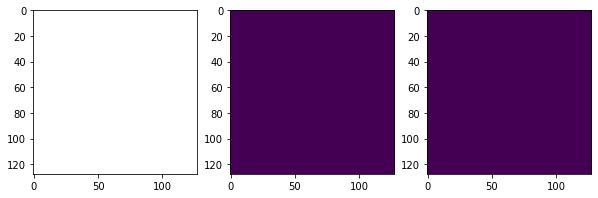

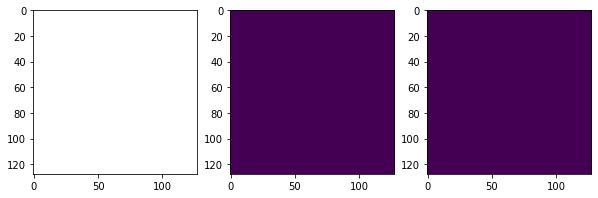

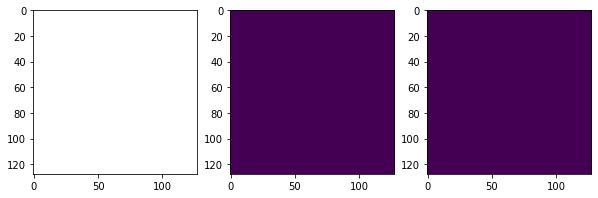

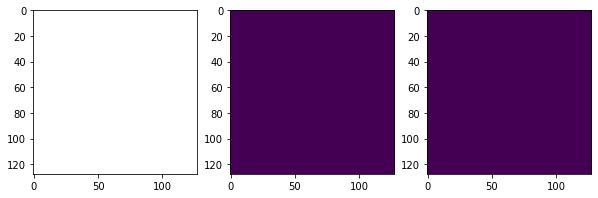

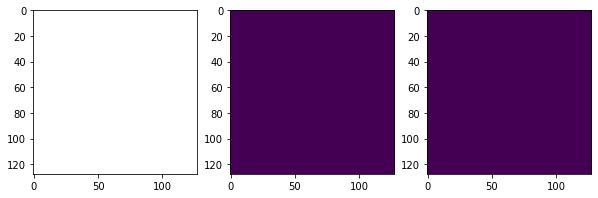

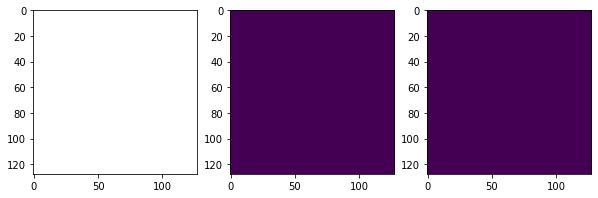

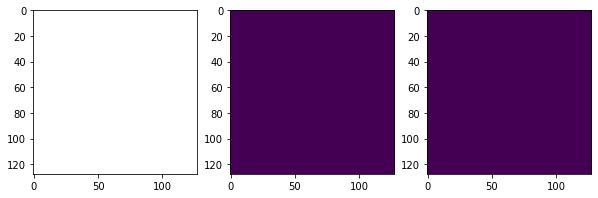

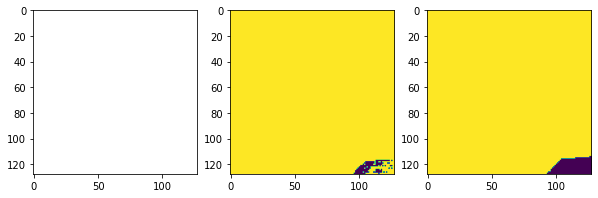

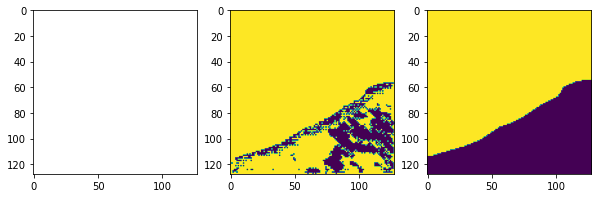

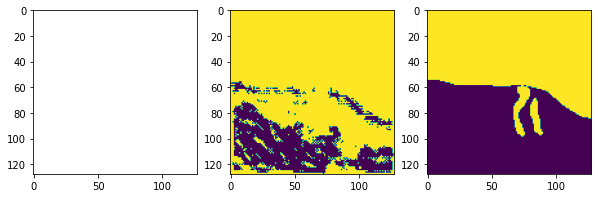

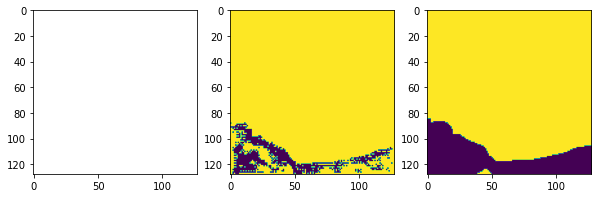

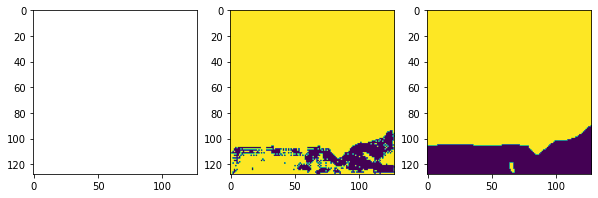

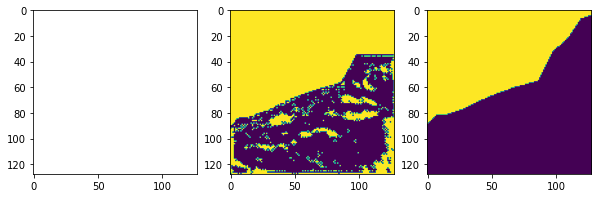

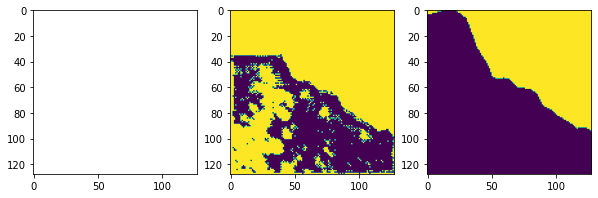

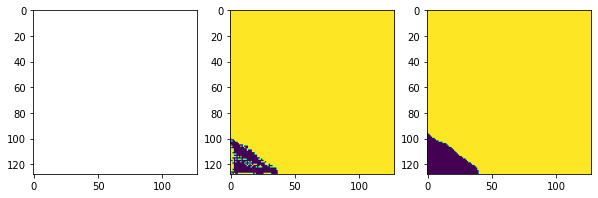

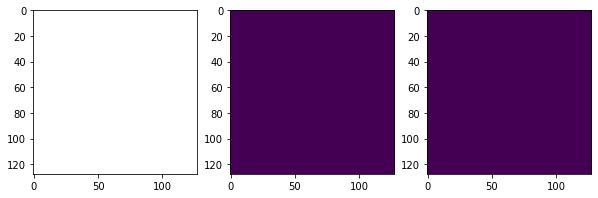

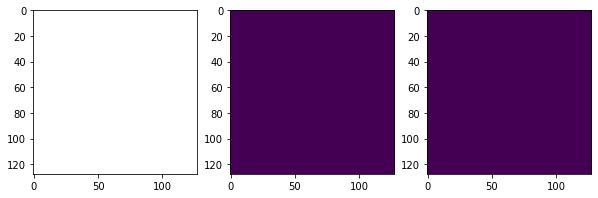

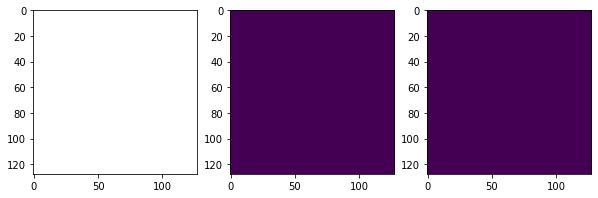

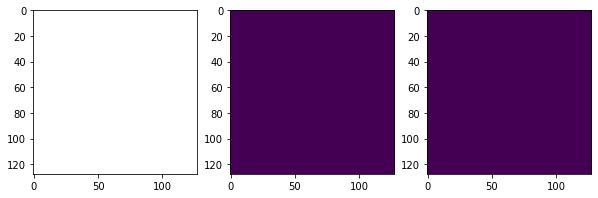

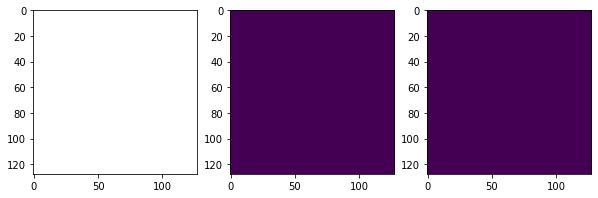

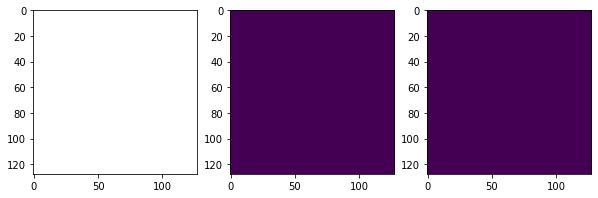

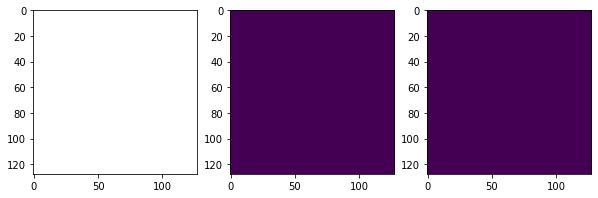

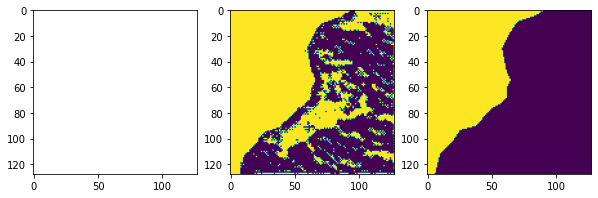

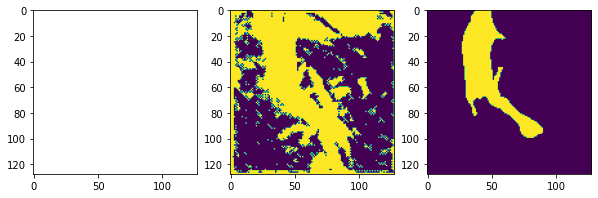

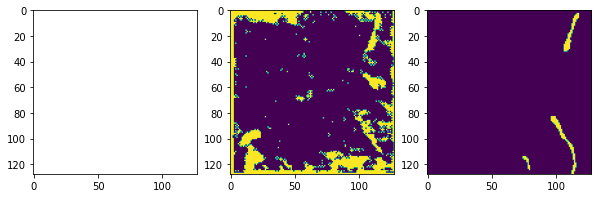

In [33]:
# Plot the first 10 predictions
for i in range(25):
    prediction = model.predict(np.expand_dims(X_test[i],axis = 0), verbose=1)
    # It's possible to change the 0.5 threshold to improve the results;
    prediction = (prediction > 0.5).astype(np.uint8)
    f, axarr = plt.subplots(1,3,figsize=(10,10))
    axarr[0].imshow(X_test[i][:,:,:3])
    axarr[1].imshow(np.squeeze(prediction))
    axarr[2].imshow(np.squeeze(Y_test[i]))